<a href="https://colab.research.google.com/github/Reem-Albadwy/apppp1/blob/main/Teeth_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdown
import gdown
url = "https://drive.google.com/uc?id=16hOWSbMpqJfpObMTs1rzCyWYabRw6Vd8"
output = "Teeth_Dataset.zip"
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=16hOWSbMpqJfpObMTs1rzCyWYabRw6Vd8
From (redirected): https://drive.google.com/uc?id=16hOWSbMpqJfpObMTs1rzCyWYabRw6Vd8&confirm=t&uuid=d5aa83cd-9b07-478e-8f9a-d03da8cc751b
To: /content/Teeth_Dataset.zip
100%|██████████| 49.1M/49.1M [00:01<00:00, 46.4MB/s]


'Teeth_Dataset.zip'

In [ ]:
import zipfile
with zipfile.ZipFile("Teeth_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Teeth_Dataset")
import os
print("Teeth_Dataset:")
print(os.listdir("Teeth_Dataset"))


Teeth_Dataset:
['Teeth_Dataset']


In [ ]:
import os
inner_path = "Teeth_Dataset/Teeth_Dataset"
print("Teeth_Dataset/Teeth_Dataset:")
print(os.listdir(inner_path))


Teeth_Dataset/Teeth_Dataset:
['Validation', 'Training', 'Testing']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
datagen=ImageDataGenerator(
    rescale=1./255
)
train_gen=datagen.flow_from_directory(
    'Teeth_Dataset/Teeth_Dataset/Training',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    seed=42
)
val_gen=datagen.flow_from_directory(
    'Teeth_Dataset/Teeth_Dataset/Validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    seed=42
)
image,labels=next(train_gen)
print(image.shape)
print(labels.shape)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
(32, 224, 224, 3)
(32, 7)


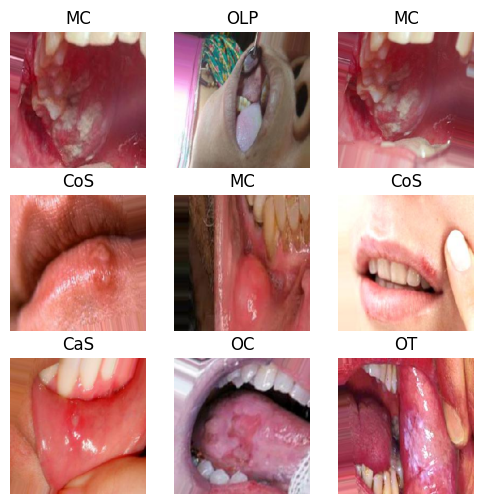

In [ ]:
class_names=list(train_gen.class_indices.keys())
plt.figure(figsize=(6,6))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image[i])
  label_index=np.argmax(labels[i])
  plt.title(class_names[label_index])
  plt.axis('off')
plt.show()

In [ ]:
augmented_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_gen=augmented_datagen.flow_from_directory(
    'Teeth_Dataset/Teeth_Dataset/Training',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    subset='training'
)
val_gen=augmented_datagen.flow_from_directory(
    'Teeth_Dataset/Teeth_Dataset/Validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    subset='validation'
)

Found 2471 images belonging to 7 classes.
Found 204 images belonging to 7 classes.


In [ ]:
x_train,y_train=next(train_gen)
print(x_train.shape)
print(y_train.shape)

(32, 224, 224, 3)
(32, 7)


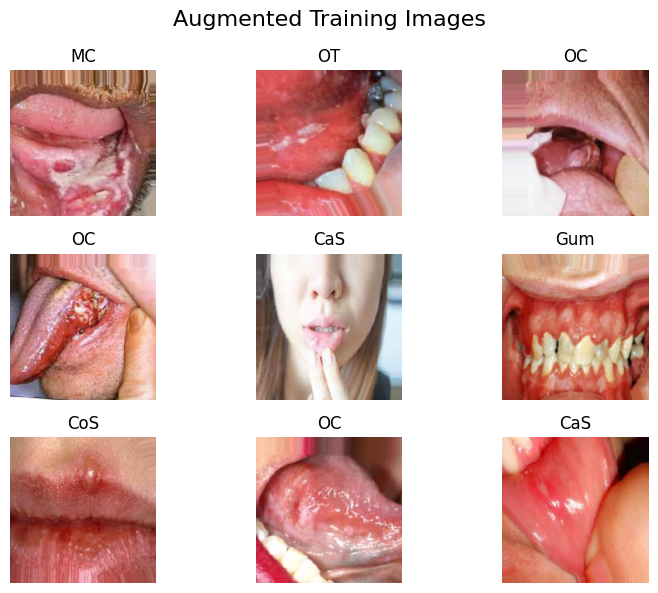

In [ ]:
class_namess=list(train_gen.class_indices.keys())
plt.figure(figsize=(8,6))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[i])
  plt.title(class_namess[np.argmax(y_train[i])])
  plt.suptitle('Augmented Training Images',fontsize=16)
  plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
x_val,y_val=next(val_gen)
print(x_val.shape)
print(y_val.shape)

(32, 224, 224, 3)
(32, 7)


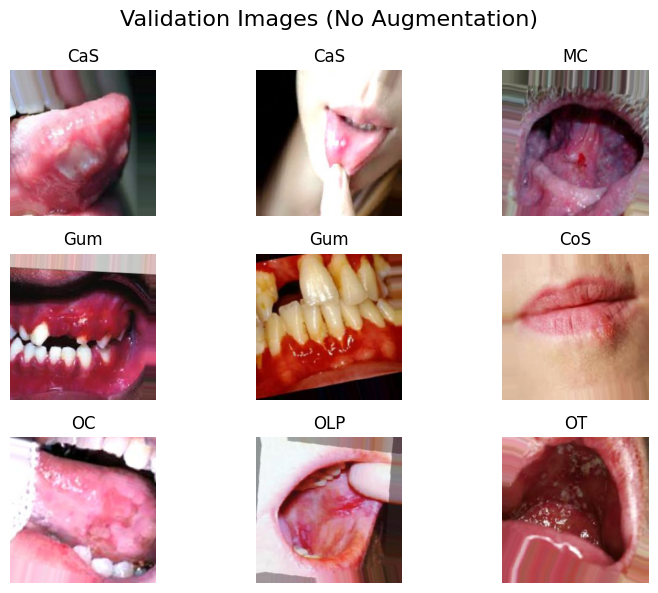

In [ ]:
class_names=list(val_gen.class_indices.keys())
plt.figure(figsize=(8,6))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_val[i])
  plt.title(class_names[np.argmax(y_val[i])])
  plt.suptitle('Validation Images (No Augmentation)',fontsize=16)
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import BatchNormalization
model=models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

In [ ]:
history=model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
31/78 ━━━━━━━━━━━━━━━━━━━━ 3:35 5s/step - accuracy: 0.5096 - loss: 1.2812

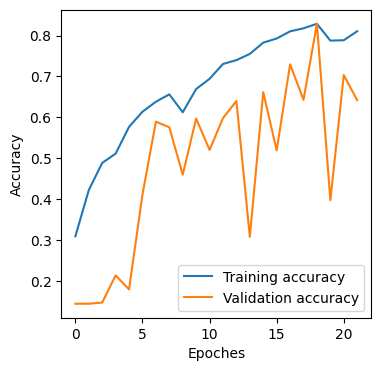

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

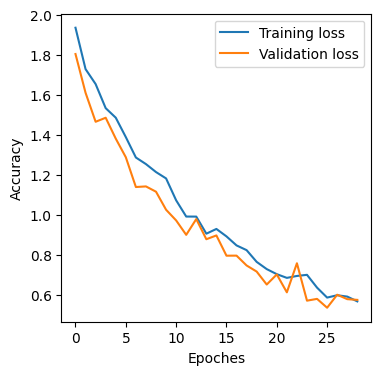

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

val_pred=model.predict(val_gen)
y_pred=np.argmax(val_pred,axis=1)
y_true=val_gen.classes
cm=confusion_matrix(y_true,y_pred)
cm

33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step


array([[33, 22, 23, 29, 12, 25, 16],
       [23, 21, 11, 29, 18, 24, 23],
       [21, 14, 15, 17, 12, 24, 17],
       [34, 23, 19, 40, 12, 23, 29],
       [20, 23,  9, 31,  7,  8, 10],
       [27, 25, 24, 33, 17, 28, 26],
       [23, 21, 16, 26, 11, 21, 13]])

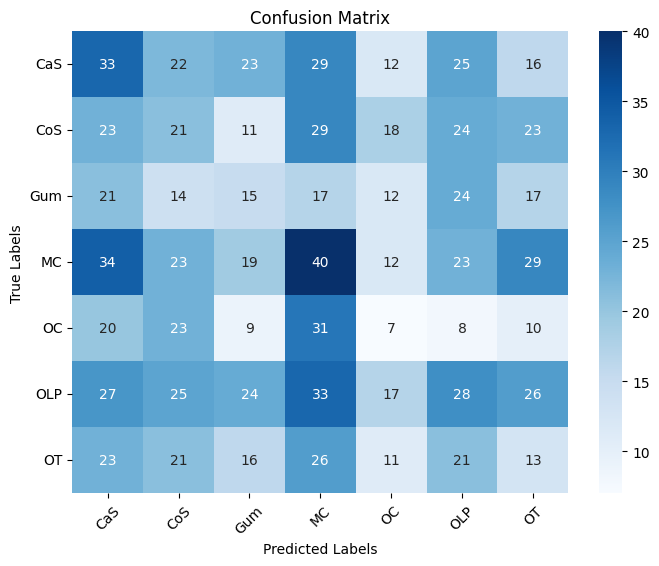

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
class_names=list(val_gen.class_indices.keys())
plt.xticks(np.array(range(7))+0.5,class_names,rotation=45)
plt.yticks(np.arange(7)+0.5,class_names,rotation=0)
plt.show()

In [24]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_gen=test_datagen.flow_from_directory(
    'Teeth_Dataset/Teeth_Dataset/Testing',
    target_size=(224,224),
    batch_size=32,
     class_mode='categorical',
    shuffle=False
)
print(os.listdir('Teeth_Dataset/Teeth_Dataset/Testing'))

Found 1508 images belonging to 10 classes.
['OLP', 'CoS', 'OC', 'CaS', 'outputs', 'OT', 'MC', 'output', 'Gum', 'out', 'output_image.jpg']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


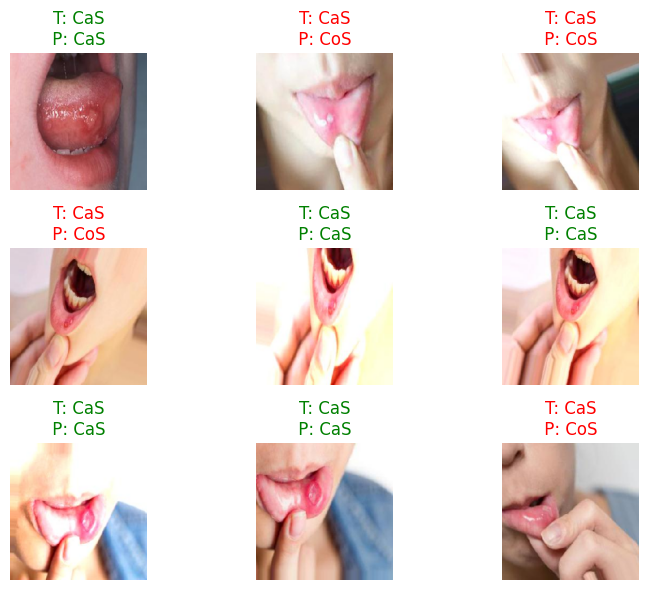

In [26]:
x_test,y_test=next(test_gen)
plt.figure(figsize=(8,6))
for i in range (9):
  plt.subplot(3,3,i+1)
  plt.imshow(x_test[i])
  true_idx=np.argmax(y_test[i])
  pred_idx=np.argmax(model.predict(x_test[i][None,...]))
  true_label=class_names[true_idx]
  pred_label=class_names[pred_idx]
  color='green' if true_idx==pred_idx else 'red'
  plt.title(f"T: {true_label}\n P: {pred_label} ",color=color)
  plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
model.save('my_teeth_model.h5')